# Using UMAP for Clustering

UMAP can be used as an effective preprocessing step to boost the performance of density based clustering. This is somewhat controversial, and should be attempted with care. For a good discussion of some of the issues involved in this please see the various answers [in this stackoverflow thread](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne) on clustering the results of t-SNE. Many of the points of concern raised there are salient for clustering the results of UMAP. The most notable is that UMAP, like t-SNE, does not completely preserve density. UMAP, like t-SNE, can also create tears in clusters that are not actually present, resulting in a finer clustering than is necessarily present in the data. Despite these concerns there are still valid reasons to use UMAP as a preprocessing step for clustering. As with any clustering approach one will want to do some exploration and evaluation of the clusters that come out to try to validate them if possible.

With all of that said, let's work through an example to demonstrate the difficulties that can face clustering approaches and how UMAP can provide a powerful tool to help overcome them.

First we'll need a selection of libraries loaded up. Obviously we'll need data, and we can use sklearn's ``fetch_mldata`` to get it. We'll also need the usual tools of numpy, and plotting. Next we'll need umap, and some clustering options. Finally, since we'll be working with labeled data, we can make use of strong cluster evaluation metrics [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index) and [Adjusted Mutual Information](https://en.wikipedia.org/wiki/Adjusted_mutual_information).

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Now let's set up the plotting and grab the data we'll be using -- in this case the MNIST handwritten digits dataset. MNIST consists of 28x28 pixel grayscale images of handwritten digits (0 through 9). These can be unraveled such that each digit is described by a 784 dimensional vector (the gray scale value of each pixel in the image). Ideally we would like the clustering to recover the digit structure.

In [2]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [3]:
mnist = fetch_mldata('MNIST Original')

For visualization purposes we can reduce the data to 2-dimensions using UMAP. When we cluster the data in high dimensions we can visualize the result of that clustering. First, however, we'll view the data a colored by the digit that each data point represents -- we'll use a different color for each digit. This will help frame what follows.

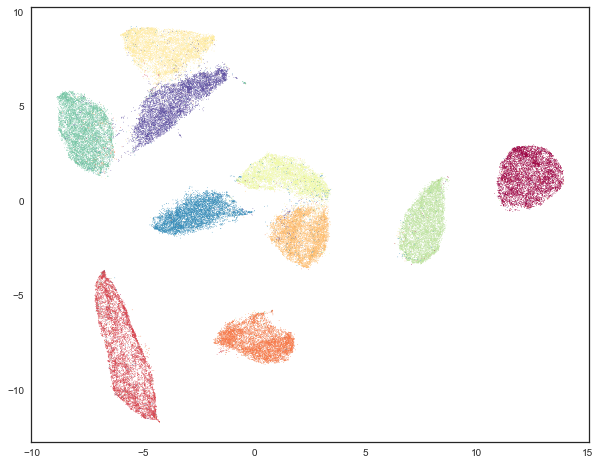

In [4]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target, s=0.1, cmap='Spectral')

### Traditional clustering

Now we would like to cluster the data. As a first attempt let's try the traditional approach: K-Means. In this case we can solve one of the hard problems for K-Means clustering -- choosing the right k value, giving the number of clusters we are looking for. In this case we know the answer is exactly 10. We will use sklearns K-Means implementation looking for 10 clusters in the original 784 dimensional data.

In [5]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(mnist.data)

And how did the clustering do? We can look at the results by coloring out UMAP embedded data by cluster membership.

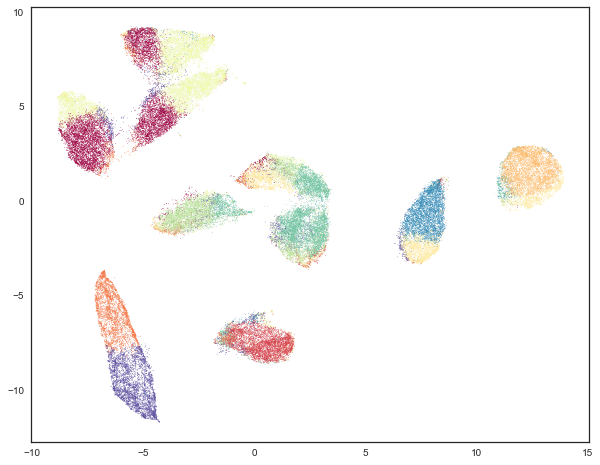

In [6]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

This is not really the result we were looking for (though it does expose interesting properties of how K-Means chooses clusters in high dimensional space, and how UMAP unwraps manifolds by finding manifold boundaries. While K-Means gets some cases correct -- the two clusters are the far right are mostly correct, most of the rest of the data looks somewhat arbitrarily carved up among the remaining clusters. We can put this impression to the test by evaluating the adjusted Rand score and adjusted mutual information for this clustering as compared with the true labels.

In [7]:
(
    adjusted_rand_score(mnist.target, kmeans_labels), 
    adjusted_mutual_info_score(mnist.target, kmeans_labels)
)

(0.36675295135972552, 0.49614118437750965)

As might be expected, we have not done a particularly good job -- both scores take values in the range 0 to 1, with 0 representing a bad (essentially random) clustering and 1 representing perfectly recovering the true labels. K-Means definitely was not random, but it was also quite a long way from perfectly recovering the true labels. Part of the problem is the way K-Means works, based on centroids with an assumption of largely spherical clusters -- this is responsible for some of the sharp divides that K-Means puts across digit classes. We can potentially improve on this by using a smarter density based algorithm. In this case we've chosen to try HDBSCAN, which we believe to be among the most advanced density based tehcniques. For the sake of performance we'll reduce the dimensionality of the data down to 50 dimensions via PCA (this recovers most of the variance), since HDBSCAN scales somewhat poorly with the dimensionality of the data it will work on.

In [8]:
lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

We can now inspect the results. Before we do, however, it should be noted that one of the features of HDBSCAN is that it can refuse to cluster some points and classify the as "noise". To visualize this aspect we will colorpoints that were classified as noise gray, and then color the remaining points according to the cluster membership.

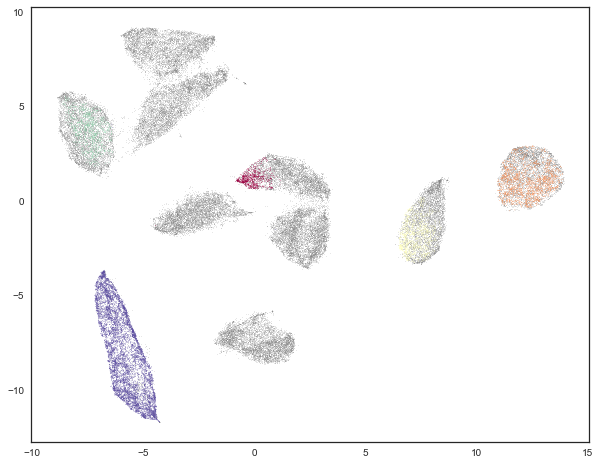

In [9]:
clustered = (hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0], 
            standard_embedding[~clustered, 1], 
            c=(0.5, 0.5, 0.5), 
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0], 
            standard_embedding[clustered, 1], 
            c=hdbscan_labels[clustered], 
            s=0.1, 
            cmap='Spectral')

This looks somewhat underwhelming. It meets HDBSCAN's approach of "not being wrong" by simply refusing the classify the majority of the data. The result is a clustering that almost certainly fails to recover all the labels. We can verify this by looking at the clustering validation scores.

In [10]:
(
    adjusted_rand_score(mnist.target, hdbscan_labels), 
    adjusted_mutual_info_score(mnist.target, hdbscan_labels)
)

(0.053830107882840102, 0.19756104096566332)

These scores are far worse than K-Means! Partially this is due to the fact that these scores assume that the noise points are simply an extra cluster. We can instead only look at the subset of the data that HDBSCAN was actually confident enough to assign to clusters -- a simple sub-selection will let us recompute the scores for only that data.

In [11]:
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], hdbscan_labels[clustered]), 
    adjusted_mutual_info_score(mnist.target[clustered], hdbscan_labels[clustered])
)

(0.99843407988303912, 0.99405521087764015)

And here we see that where HDBSCAN was willing to cluster it got things almost entirely correct. This is what it was designed to do -- be right for what it can, and defer on anything that it couldn't have sufficient confidence in. Of course the catch here is that it deferred clustering a lot of the data. How much of the data did HDBSCAN actually assign to clusters? We can compute that easily enough.

In [12]:
np.sum(clustered) / mnist.data.shape[0]

0.17081428571428572

It seems that less than 18% of the data was clustered. While HDBSCAN did a great job on the data it could cluster it did a poor job of actually managing to cluster the data. The problem here is that, as a density based clustering algorithm, HDBSCAN tends to suffer from the curse of dimensionality: high dimensional data requires more observed samples to produce much density. If we could reduce the dimensionality of the data more we would make the density more evident and make it far easier for HDBSCAN to cluster the data. The problem is that trying to use PCA to do this is going to become problematic. While reducing the 50 dimensions still explained a lot of the variance of the data, reducing further is going to quickly do a lot worse. This is due to the linear nature of PCA. What we need is strong manifold learning, and this is where UMAP can come into play.

### UMAP enhanced clustering

Our goal is to make use of UMAP to perform non-linear manifold aware dimension reduction so we can get the dataset down to a number of dimensions small enough for a density based clustering algorithm to make progress. One advantage of UMAP for this is that it doesn't require you to reduce to only two dimensions -- you can reduce to 10 dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal. As it happens MNIST is such a simple dataset that we really can push it all the way down to only two dimensions, but in general you should explore different embedding dimension options.

The next thing to be aware of is that when using UMAP for dimension reduction you will want to select different parameters than if you were using it for visualization. First of all we will want a larger ``n_neighbors`` value -- small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In this case we'll double it from the default 15 up to 30. Second it is beneficial to set ``min_dist`` to a very low value. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set ``min_dist`` to be 0.

In [13]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(mnist.data)

We can visualize the results of this so see how it compares with more visualization attuned parameters:

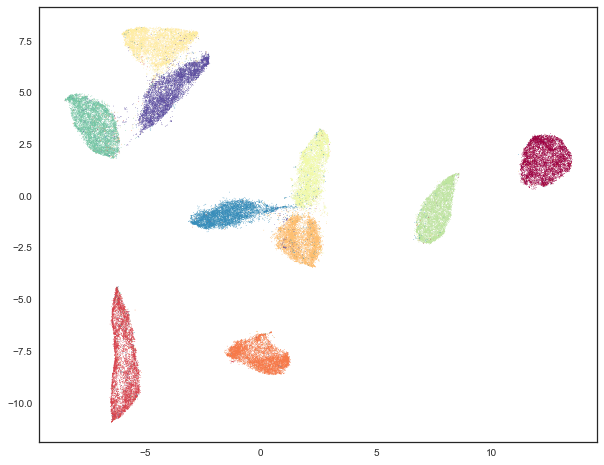

In [14]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=mnist.target, s=0.1, cmap='Spectral')

As you can see we still have the general global structure, but we are packing points together more tightly within clusters, and consequently we can see larger gaps between the clusters. Ultimately this embedding was for clustering purposes only, and we will go back to the original embedding for visualization purposes from here on out.

The next step is to cluster this data. We'll use HDBSCAN again, with the same parameter setting as before.

In [15]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

And now we can visualize the results, just as before.

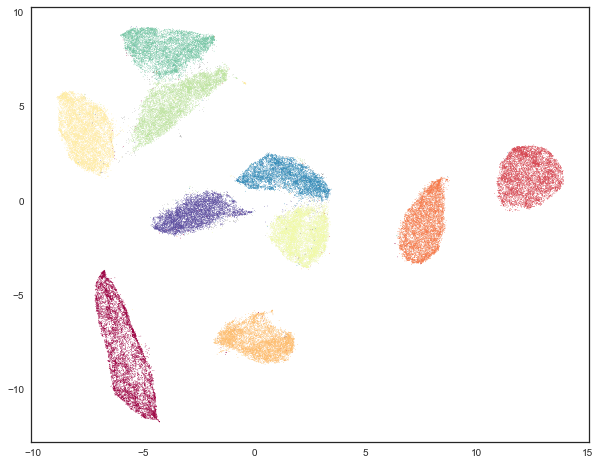

In [16]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0], 
            standard_embedding[~clustered, 1], 
            c=(0.5, 0.5, 0.5), 
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0], 
            standard_embedding[clustered, 1], 
            c=labels[clustered], 
            s=0.1, 
            cmap='Spectral')

We can see that we have done a much better job of finding clusters rather than merely assigning the majority of data as noise. This is because we have we no longer have to try to cope with the relative lack of density in 50 dimensional space and now HDBSCAN can more cleanly discern the clusters.

We can also make a quantitative assessment by using the clustering quality measures as before.

In [17]:
adjusted_rand_score(mnist.target, labels), adjusted_mutual_info_score(mnist.target, labels)

(0.9239306564265013, 0.90302671641133736)

Where before HDBSCAN performed very poorly, we now have score of 0.9 or better. This is because we actually clustered far more of the data. As before we can also look at how the clustering did on just the data that HDBSCAN was confident in clustering.

In [18]:
clustered = (labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], labels[clustered]), 
    adjusted_mutual_info_score(mnist.target[clustered], labels[clustered])
)

(0.93240371696811541, 0.91912906363537572)

This is a little worse than the original HDBSCAN, but it is unsurprising that you are going to be wrong more often if you make more predictions. The question is how much more of the data is HDBSCAN actually clustering? Previously we were clustering only 17% of the data.

In [19]:
np.sum(clustered) / mnist.data.shape[0]

0.99164285714285716

Now we are clustering over 99% of the data! And our results in terms of adjusted Rand score and adjusted mutual information are in line with the current state of the art techniques using convolutional autoencoder techniques. That's not bad for an approach that is simply viewing the data as arbitrary 784 dimensional vectors.

Hopefully this has outlined how UMAP can be beneficial for clustering. As with all thing care must be taken, but clearly UMAP can provide significantly better clustering results when used judiciously.